In [4]:
max_item_count = 24
rarity_thershold = 100
active_value = 1

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [6]:


csv_file_path_train = './train_dataset.csv'
csv_file_path_test = './submission_data_x.csv'

df_train = pd.read_csv(csv_file_path_train)
df_test = pd.read_csv(csv_file_path_test)


C:\Users\ethem\AppData\Local\Temp\ipykernel_11920\657259393.py:4: DtypeWarning: Columns (11,12,13,14,15,16,17,18,19,20,21,22,23,24,59,60,61,62,63,64,65,66,67,68,69,70,71,72,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,102,103,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(csv_file_path_train)
C:\Users\ethem\AppData\Local\Temp\ipykernel_11920\657259393.py:5: DtypeWarning: Columns (97,105,107,108,109,110,111,112,113,114,116,117,118,119) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(csv_file_path_test)


In [7]:
df_train = pd.read_csv(csv_file_path_train)

C:\Users\ethem\AppData\Local\Temp\ipykernel_11920\222863778.py:1: DtypeWarning: Columns (11,12,13,14,15,16,17,18,19,20,21,22,23,24,59,60,61,62,63,64,65,66,67,68,69,70,71,72,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,102,103,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(csv_file_path_train)


In [8]:
# Manage the TEST data
col_list = ["item", "make", "model", "goods_code"]
all_colmns_to_append = []
for clmn_name in col_list:

    # Extract uniqueness and repetiteveness
    row_count = df_test.shape[0]
    count_dict = defaultdict(int)
    
    cols = {clmn_name+str(i) for i in range(1,max_item_count+1)}

    for col in cols:
        column_values = df_test[col]
        # del df_test[col]
        for row in range(row_count - 1):
            item = column_values[row]
            if pd.notna(item):
                count_dict[str(item)] += 1

    count_dict = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    
    # ADD COLUMNS  
    for key, count in count_dict:
        if count > rarity_thershold:
            all_colmns_to_append.append(str(key))

all_colmns_to_append = list(set(all_colmns_to_append))
new_data = pd.DataFrame(0, index=df_test.index, columns=all_colmns_to_append)
df_test = pd.concat([df_test, new_data], axis=1)

for clmn_name in col_list:
    cols = {clmn_name+str(i) for i in range(1,max_item_count+1)}
    # FILL NEWLY ADDED COLUMNS
    for index, row in df_test.iterrows():
        for col in cols:
            cell = row[col]
            if not pd.notna(cell):
                break
            if cell in df_test.columns:
                df_test.at[index, cell] = 1

    # DROP OLD COLUMNS
    for col in cols:
        del df_test[col]


In [9]:
# Manage the TRAIN data

# ADD COLUMNS
cols_df_test = list(df_test.columns)
cols_df_train = list(df_train.columns)
cols_add_train = []

for col in cols_df_test:
    if col not in cols_df_train:
        cols_add_train.append(col)

new_data = pd.DataFrame(0, index=df_train.index, columns=cols_add_train)
df_train = pd.concat([df_train, new_data], axis=1)

for clmn_name in col_list:

    cols = {clmn_name+str(i) for i in range(1,max_item_count+1)}

    # # FILL NEWLY ADDED COLUMNS
    for index, row in df_train.iterrows():
        for col in cols:
            cell = row[col]
            if not pd.notna(cell):
                break
            if cell in df_train.columns:
                df_train.at[index, cell] = active_value

    # DROP OLD COLUMNS
    for col in cols:
        del df_train[col]

In [10]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [11]:
train_x, test_x = train_test_split(df_train, test_size=0.2, random_state=342)
train_x = train_x[train_x.fraud_flag == 0]       # where normal transactions
train_x = train_x.drop(['fraud_flag'], axis=1)   # drop the class column


test_y = test_x['fraud_flag']                    # save the class column for the test set
test_x = test_x.drop(['fraud_flag'], axis=1)     # drop the class column

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray

In [12]:
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix, precision_recall_curve
import seaborn as sns
import numpy as np


In [13]:
nb_epoch = 500
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 80
hidden_dim1 = 30 #int(encoding_dim / 2) #i.e. 7
hidden_dim2 = 3
learning_rate = 1e-5


In [14]:
# This returns a tensor
input_layer = Input(shape=(input_dim, ))

# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and 
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# activity_regularizer: Regularizer function applied to the output of the layer
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="elu")(encoder)
encoder = Dense(hidden_dim2, activation="tanh")(encoder)
decoder = Dense(hidden_dim2, activation='elu')(encoder)
decoder = Dense(hidden_dim1, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [15]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')

# Saving the model
cp = ModelCheckpoint(filepath="autoencoder_fraud.keras",
                     save_best_only=True,
                     verbose=0)

# TensorBoard basic visualizations.
# This callback writes a log for TensorBoard, 
# which allows you to visualize dynamic graphs of your training and test metrics
tb = TensorBoard(log_dir='/logss',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)

# Starts training
# autoencoder: same training(x) and target data(y)
# validation_data: tuple (x_val, y_val) on which 
# to evaluate the loss and any model metrics at the end of each epoch.

# History.history attribute is a record of training loss values 
# and metrics values at successive epochs.
history = autoencoder.fit(x=train_x, y=train_x,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(test_x, test_x),
                          verbose=1,
                          callbacks=[cp, tb]).history

Epoch 1/500
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8279 - loss: 27498942.0000 - val_accuracy: 0.9915 - val_loss: 27395986.0000
Epoch 2/500
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9914 - loss: 27495056.0000 - val_accuracy: 0.9915 - val_loss: 27385016.0000
Epoch 3/500
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9922 - loss: 27592724.0000 - val_accuracy: 0.9915 - val_loss: 27374456.0000
Epoch 4/500
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9918 - loss: 27462654.0000 - val_accuracy: 0.9915 - val_loss: 27364054.0000
Epoch 5/500
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9910 - loss: 27550394.0000 - val_accuracy: 0.9915 - val_loss: 27353720.0000
Epoch 6/500
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9916 - loss: 27480984.0000 - val_accuracy: 0.9915 - val_loss: 27343440.0000
Epoch 7/500
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9916 - loss: 27349516.0000 - val_accuracy: 0.9915 - val_loss: 27333172.0000

In [16]:
autoencoder = load_model('autoencoder_fraud.keras')

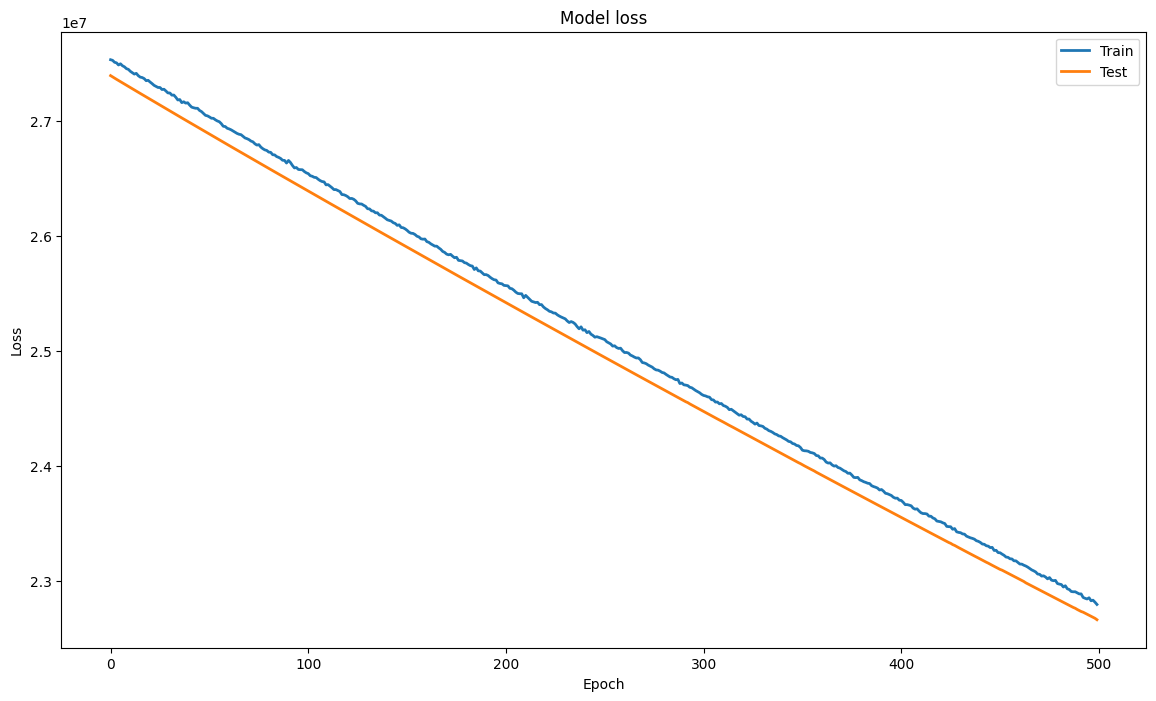

In [17]:
plt.figure(figsize=(14, 8))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [18]:

len(test_x)

14846

In [19]:

test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


,Reconstruction_error,True_class
count,1.484600e+04,14846.000000
mean,2.266634e+07,0.013539
std,2.162647e+07,0.115571
min,5.018818e+01,0.000000
25%,3.019905e+06,0.000000
50%,1.606137e+07,0.000000
75%,3.888490e+07,0.000000
max,7.273722e+07,1.000000


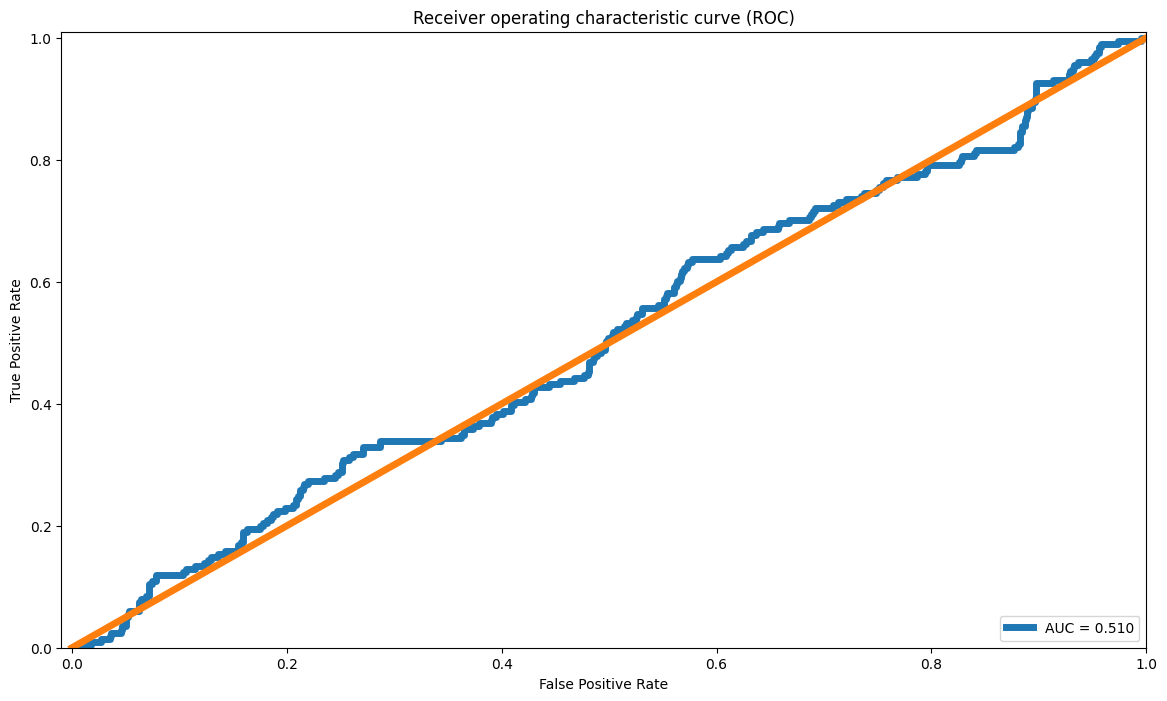

In [20]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.figure(figsize=(14, 8))
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

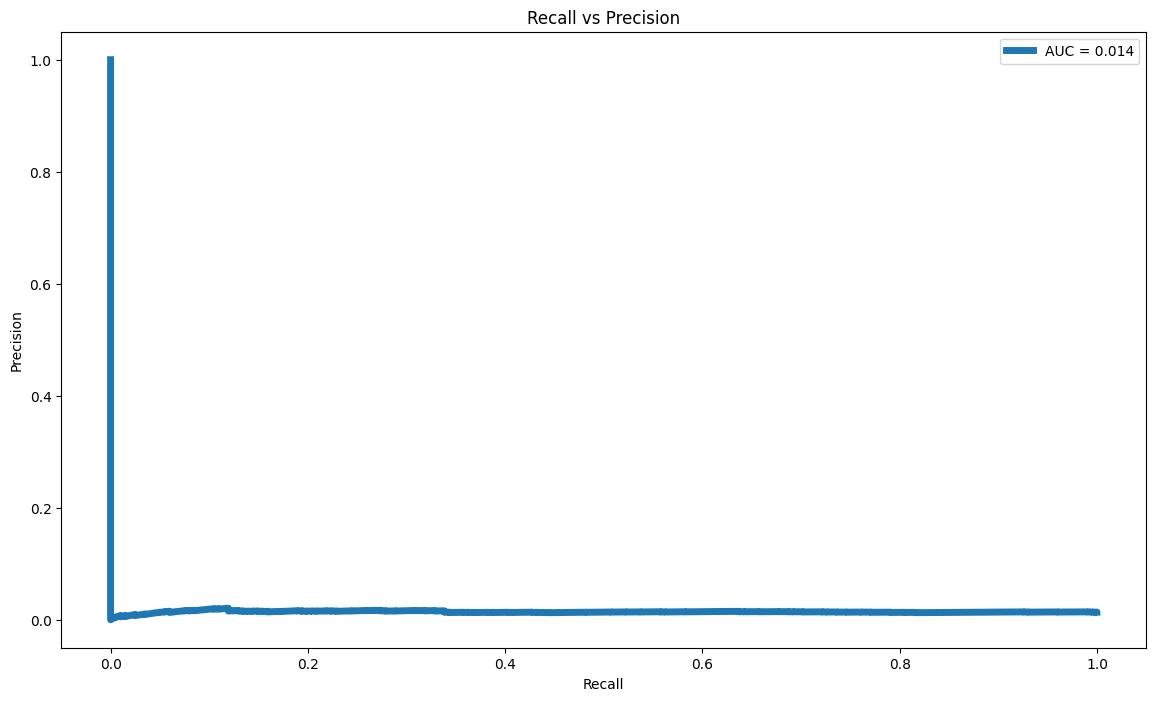

In [21]:
# calculates precision/recall using reconstruction error as the decision function
# returns: 
# precision_rt: Precision values such that element i is the precision of predictions with 
#               score >= thresholds[i] and the last element is 1.
# recall_rt: Decreasing recall values such that element i is the recall of predictions with 
#           score >= thresholds[i] and the last element is 0.
# threshold_rt = Increasing thresholds on the decision function used to compute
#                precision and recall.
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class,
                                                               error_df.Reconstruction_error)

pr_auc = auc(recall_rt, precision_rt,)

plt.figure(figsize=(14, 8))
plt.plot(recall_rt, precision_rt, linewidth=5, label='AUC = %0.3f'% pr_auc)
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

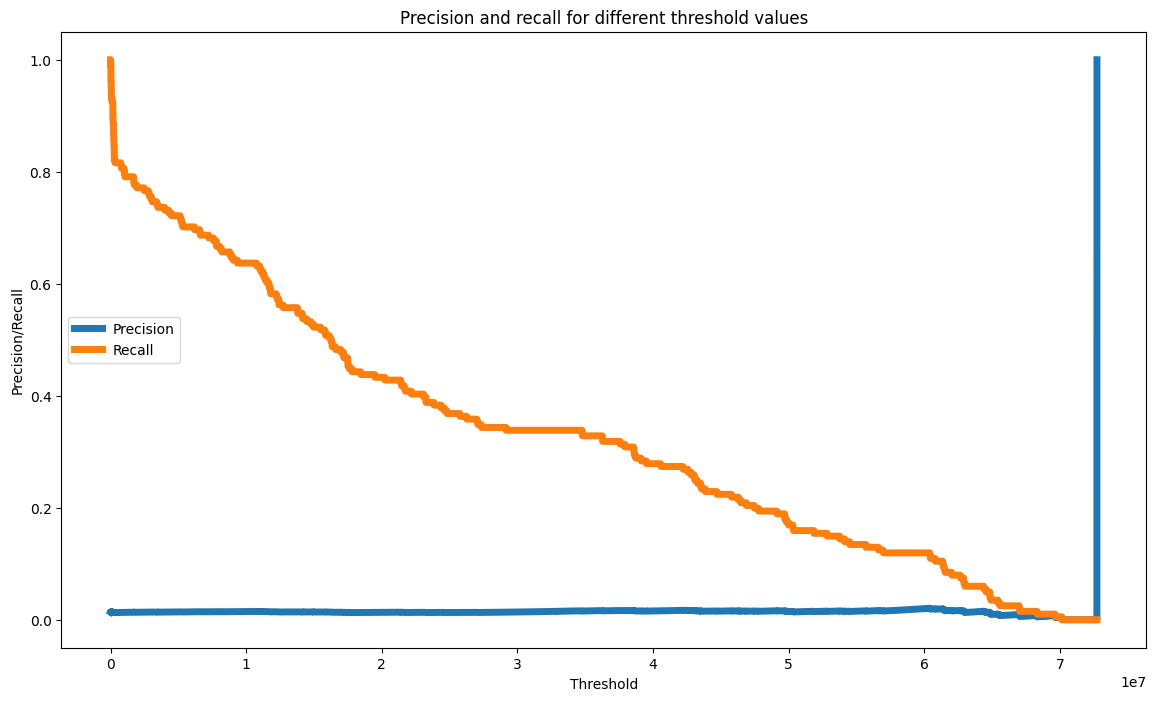

In [22]:
plt.figure(figsize=(14, 8))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

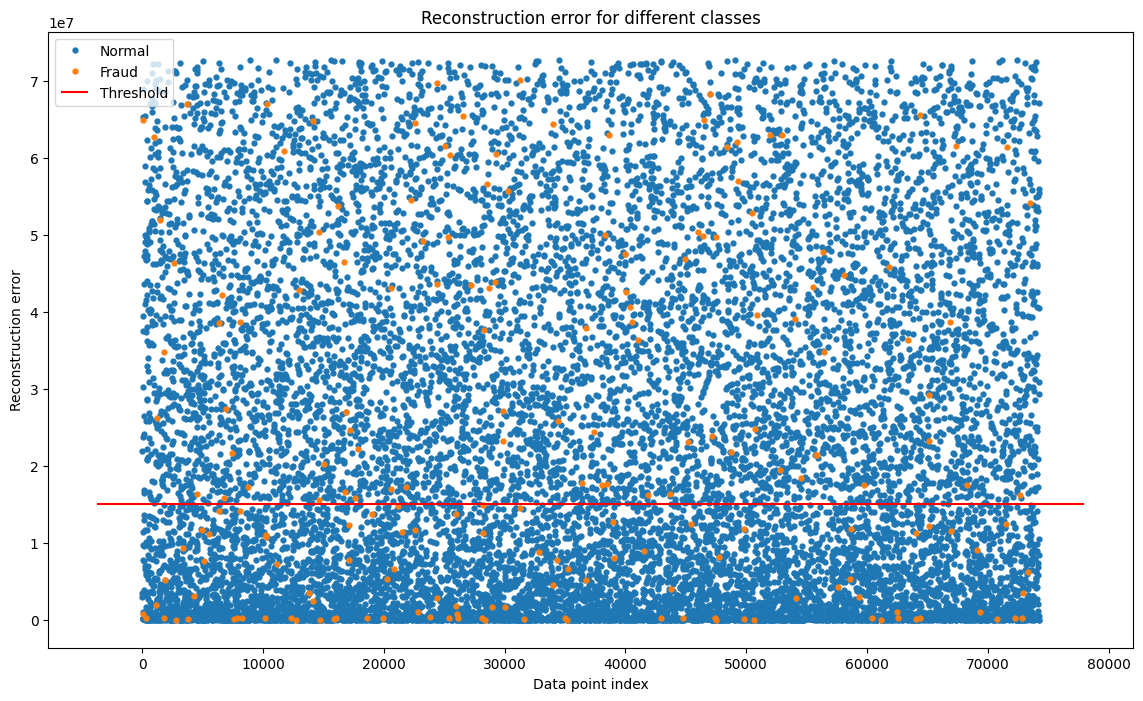

In [23]:
threshold_fixed = 15000000
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(14, 8))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

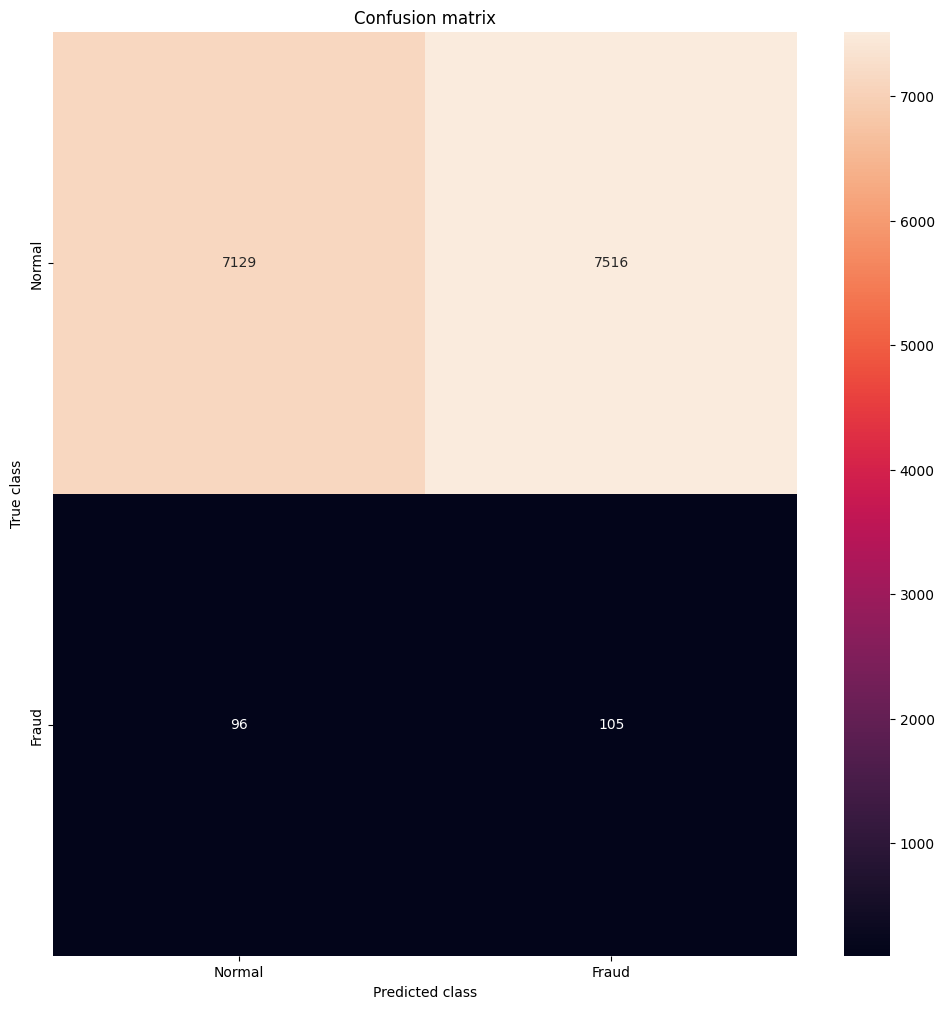

In [24]:
# As with autoencoders, it is the assumption that fraud or anomalies will suffer 
# from a detectably high reconstruction error, predicting class as 1 (Fraud)
# if reconstruction error is greater than threshold
LABELS = ["Normal","Fraud"]
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [25]:
test_x = df_test
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
msp_np = np.array(mse)

# Min-Max Normalizasyonu
min_val = np.min(msp_np)
max_val = np.max(msp_np)
normalized_data = (msp_np - min_val) / (max_val - min_val)

print(len(normalized_data))

580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
18558


In [27]:
with open("submission_data_x.csv", "r") as file:
    lines = file.readlines()


new_lines = []
for i, prob in enumerate(normalized_data):
    new_lines.append(f"{lines[i + 1].strip()}{prob}\n")

with open("autoencoder_results.csv", "w") as file:
    file.write("ID,fraud_flag\n")
    file.writelines(new_lines)
